In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 가상 데이터: 사용자 500명, 상품 1000개. 상호작용 데이터 (User ID, Item ID, Rating/Interaction)
class RatingDataset(Dataset):
    def __init__(self, num_users=500, num_items=1000, num_interactions=20000):
        # User ID, Item ID, Interaction Score (0 또는 1)
        self.data = np.random.randint(0, num_users, size=(num_interactions, 1))
        self.data = np.hstack((self.data, np.random.randint(0, num_items, size=(num_interactions, 1))))
        self.data = np.hstack((self.data, np.random.randint(0, 2, size=(num_interactions, 1)))) # 0: No, 1: Yes
        self.data = self.data.astype(np.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user_id = self.data[idx, 0]
        item_id = self.data[idx, 1]
        label = self.data[idx, 2]
        return torch.tensor(user_id), torch.tensor(item_id), torch.tensor(label, dtype=torch.float32)

# 데이터로더 설정
train_dataset = RatingDataset()
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [2]:
import numpy as np

def create_item_mapping(num_items):
    mapping = {}
    MAX_PYUNG = 100  # 에어컨이 들어갈 최대 평수
    MAX_SMART_WATCH_MODEL = 25 # 스마트 워치 최대 모델 번호 (S1 ~ S25)

    # 2. 모든 상품 ID에 대해 유효한 상품명을 할당
    for i in range(num_items):

        if i % 5 == 0:
            # TV: 랜덤 인치 (30~80인치)
            size = np.random.randint(30, 81)
            name = f"프리미엄 4K TV ({size}인치)"

        elif i % 5 == 1:
            # 에어컨: 최대 평형(100) 내의 랜덤 평형
            pyung = np.random.randint(5, MAX_PYUNG + 1)
            name = f"dual inverter 에어컨 {pyung}평형"

        elif i % 5 == 2:
            # 무선 이어폰: 작은 숫자의 버전명
            version = np.random.randint(1, 15)
            name = f"iphone{version}"

        elif i % 5 == 3:
            # 로봇 청소기: 작은 숫자의 모델명
            model_num = np.random.randint(1, 200)
            name = f"AI 로봇 청소기 Model-{model_num}"

        else: # i % 5 == 4
            # 스마트 워치: 최대 S25 내의 랜덤 모델명
            model_num = np.random.randint(1, MAX_SMART_WATCH_MODEL + 1)
            name = f"galaxy S{model_num}"

        mapping[i] = name
    return mapping

# ITEM_MAPPING 변수를 이 새로운 함수로 다시 생성
ITEM_MAPPING = create_item_mapping(num_items=1000)


In [3]:
import torch.nn as nn

class DeepRecommendationModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=50):
        super(DeepRecommendationModel, self).__init__()

        # 1. 사용자 임베딩 레이어 (Embedding Layer)
        # 각 사용자와 상품을 'embedding_dim' 차원의 벡터로 변환
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # 2. 편향(Bias) 항 (옵션이지만 추천 시스템에서 중요)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        # 임베딩 가중치 초기화 (산업 표준에서는 Xavier 또는 Kaiming 초기화 사용)
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)

    def forward(self, user_id, item_id):
        # 사용자 및 상품 임베딩 벡터 추출
        u_vector = self.user_embedding(user_id) # Shape: (Batch, Embedding_dim)
        i_vector = self.item_embedding(item_id) # Shape: (Batch, Embedding_dim)

        # 1. 임베딩 내적 (Dot Product): 사용자와 상품의 유사도 계산
        # torch.sum을 통해 각 배치 요소별로 내적 결과를 스칼라 값으로 변환
        dot_product = torch.sum(u_vector * i_vector, dim=1, keepdim=True)

        # 2. 편향 항 추가
        u_bias = self.user_bias(user_id)
        i_bias = self.item_bias(item_id)

        # 최종 예측 점수: 내적 + 사용자 편향 + 상품 편향
        # Sigmoid를 적용하여 결과값을 0과 1 사이의 확률로 변환 (Interaction 예측)
        prediction = torch.sigmoid(dot_product + u_bias + i_bias)

        return prediction.squeeze()

# 모델 인스턴스 생성 (num_users, num_items는 데이터셋에서 가져와야 함)
num_users = 500
num_items = 1000
model = DeepRecommendationModel(num_users, num_items)

In [4]:
import torch

# num_users와 num_items는 이전 모델 정의 시 사용한 값과 동일해야 합니다.
num_users = 500
num_items = 1000

# 이전 DeepRecommendationModel 클래스가 정의되어 있다고 가정합니다.
# (이 코드를 실행하려면 이전 답변의 모델 정의 클래스가 필요합니다.)

def recommend_for_user_with_names(model_path, item_mapping, user_id_target=10, num_items=1000):
    # 1. 모델 로드 및 추론 (이전과 동일)
    loaded_model = DeepRecommendationModel(num_users, num_items)
    # *주의: 모델 로드 시 map_location을 설정하지 않으면 오류가 발생할 수 있습니다.
    loaded_model.load_state_dict(torch.load(model_path))
    loaded_model.eval()

    # 추론 준비
    all_item_ids = torch.arange(num_items)
    user_ids_repeated = torch.tensor([user_id_target] * num_items)

    with torch.no_grad():
        scores = loaded_model(user_ids_repeated, all_item_ids)

    # 점수가 높은 상위 5개 상품 ID를 추출
    top_scores, top_indices = torch.topk(scores, 5)

    # 2. 상품 ID를 상품명으로 변환
    recommended_item_ids = top_indices.numpy()
    recommended_names = [item_mapping[id] for id in recommended_item_ids]

    print(f"\n--- 사용자 {user_id_target}에 대한 추천 상품 (상품명 포함) ---")
    print("-------------------------------------------------")

    # 결과 출력
    for name, score in zip(recommended_names, top_scores.numpy()):
        print(f"상품명: {name:<20} | 예측 점수(확률): {score:.4f}")
    print("-------------------------------------------------")

# 실행 예시:
# recommend_for_user_with_names('recommendation_prototype.pth', ITEM_MAPPING)
# (실제 실행을 위해서는 이전 모델 학습 코드가 선행되어야 합니다.)

 시도 1/10 완료. 평균 Loss: 0.9072
 시도 2/10 완료. 평균 Loss: 0.8427
 시도 3/10 완료. 평균 Loss: 0.6734
 시도 4/10 완료. 평균 Loss: 0.4495
 시도 5/10 완료. 평균 Loss: 0.2862
 시도 6/10 완료. 평균 Loss: 0.1940
 시도 7/10 완료. 평균 Loss: 0.1415
 시도 8/10 완료. 평균 Loss: 0.1105
 시도 9/10 완료. 평균 Loss: 0.0899
 시도 10/10 완료. 평균 Loss: 0.0770


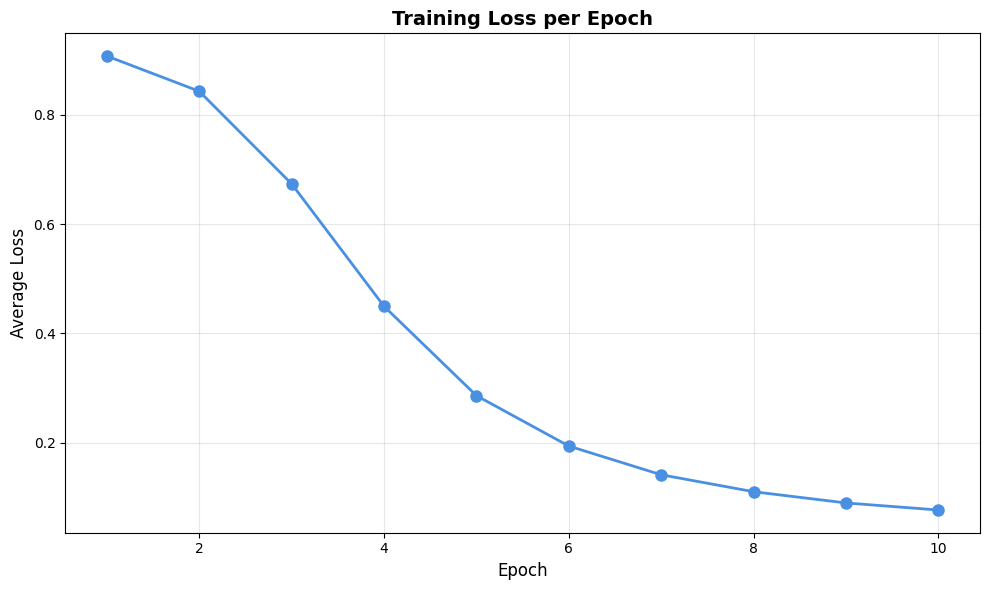


--- 사용자 10에 대한 추천 상품 (상품명 포함) ---
-------------------------------------------------
상품명: AI 로봇 청소기 Model-178  | 예측 점수(확률): 0.9966
상품명: galaxy S17           | 예측 점수(확률): 0.9924
상품명: iphone13             | 예측 점수(확률): 0.9879
상품명: galaxy S11           | 예측 점수(확률): 0.9877
상품명: 프리미엄 4K TV (78인치)    | 예측 점수(확률): 0.9875
-------------------------------------------------


In [5]:

import torch.optim as optim
import matplotlib.pyplot as plt

# 손실 함수 및 옵티마이저 설정
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

# 훈련 함수 (시각화 추가)
def train_recommendation_model(model, loader, criterion, optimizer, num_epochs=10):
    # 각 epoch의 평균 loss를 저장 (이 줄만 추가!)
    epoch_losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        for user_ids, item_ids, labels in loader:
            optimizer.zero_grad()

            # 순전파
            outputs = model(user_ids, item_ids)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 역전파
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 평균 Loss 계산 및 저장
        avg_loss = total_loss / len(loader)
        epoch_losses.append(avg_loss)
        print(f" 시도 {epoch+1}/{num_epochs} 완료. 평균 Loss: {avg_loss:.4f}")

    # 훈련 완료 후 시각화
    visualize_training_loss(epoch_losses, num_epochs)

    return epoch_losses

# 시각화 함수
def visualize_training_loss(losses, num_epochs):
    plt.figure(figsize=(10, 6))
    epochs = range(1, num_epochs + 1)

    plt.plot(epochs, losses, marker='o', linewidth=2, markersize=8, color='#4A90E2')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Average Loss', fontsize=12)
    plt.title('Training Loss per Epoch', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 모델 훈련 실행
epoch_losses = train_recommendation_model(model, train_loader, criterion, optimizer)

# 모델 저장
torch.save(model.state_dict(), 'recommendation_prototype.pth')

# 추천 실행
recommend_for_user_with_names('recommendation_prototype.pth', ITEM_MAPPING)